In [1]:
print '这次我准备利用10582的数据集进行多标签分类的训练了'
import lib.Experiment as ex
from datasets.VOC_dataset_aug import VOC_dataset_aug
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import numpy as np
from sklearn.metrics import average_precision_score
from torch.autograd.variable import Variable
import torch.utils.data
import torchvision.transforms as transforms
import networks.VGG16_224 as vgg_model
from lib.loss import MultiLabelClsV1
import os
import networks.test as ts
def compute_mAP(labels,outputs):
    y_true = labels.cpu().numpy()
    y_pred = outputs.cpu().numpy()
    AP = []
    for i in range(y_true.shape[0]):
        AP.append(average_precision_score(y_true[i],y_pred[i]))
    return np.mean(AP)
ex_dir='./data/training_luo_v2_10582aug'
batch_size=4
workers=4
epoch_num=20
ex.check_dir(ex_dir)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
voc_train=VOC_dataset_aug(train='train', transform=transforms.Compose([transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]), label_transform=None )
voc_val=VOC_dataset_aug(train='val', transform=transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor()]),
                    label_transform=None  )
train_loader = torch.utils.data.DataLoader(voc_train,
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=True)
val_loader = torch.utils.data.DataLoader(voc_val,
    batch_size=batch_size, shuffle=False,
    num_workers=workers, pin_memory=True)
print '加载数据集完成'

这次我准备利用10582的数据集进行多标签分类的训练了
加载数据集完成


In [2]:
model=vgg_model.get_VGG16_224_model()
model.cuda()
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
print '加载模型完成'

加载模型完成


开始训练
red==train;green==val...initial plt
train epoch 0 step 49, mean loss=0.098900, mean mAp=84.6907
train epoch 0 step 99, mean loss=0.100159, mean mAp=84.2910
train epoch 0 step 149, mean loss=0.102356, mean mAp=83.5408
train epoch 0 step 199, mean loss=0.104954, mean mAp=83.7196
train epoch 0 step 249, mean loss=0.106091, mean mAp=83.6039
train epoch 0 step 299, mean loss=0.106139, mean mAp=83.8866
train epoch 0 step 349, mean loss=0.106500, mean mAp=83.6988
train epoch 0 step 399, mean loss=0.108354, mean mAp=83.1519
train epoch 0 step 449, mean loss=0.107237, mean mAp=83.3493
train epoch 0 step 499, mean loss=0.107644, mean mAp=83.6531
train epoch 0 step 549, mean loss=0.107550, mean mAp=83.8060
train epoch 0 step 599, mean loss=0.107828, mean mAp=83.9837
train epoch 0 step 649, mean loss=0.108061, mean mAp=83.9034
train epoch 0 step 699, mean loss=0.108151, mean mAp=83.9624
train epoch 0 step 749, mean loss=0.108701, mean mAp=83.8023
train epoch 0 step 799, mean loss=0.108563, me

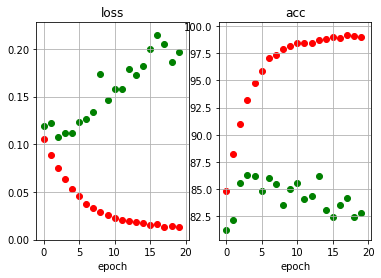

In [7]:
import matplotlib.pyplot as plt
print '开始训练'
print 'red==train;green==val...initial plt'
fig=plt.figure()
ax_loss=fig.add_subplot(1,2,1)
plt.title('loss')
plt.xlabel("epoch") 
ax_acc=fig.add_subplot(1,2,2)
plt.title('acc')
plt.xlabel("epoch")  
ax_loss.grid(True) #添加网格
ax_acc.grid(True) #添加网格
for t in range(epoch_num):
    model.train()
    mAP_train = []
    loss_train= []
    for i, (img, label) in enumerate(train_loader):
        img = img.cuda()
        label = label.cuda()
        label = Variable(label)
        input_img = Variable(img)

        output = model(input_img)
        model.zero_grad()
        mAP_train.append(compute_mAP(label.data, output.data))#计算准确率
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        loss_train.append(loss.data.cpu()[0])
        if (i+1)%50 == 0:
            print "train epoch %d step %d, mean loss=%.6f, mean mAp=%.4f"%(t, i, np.mean(loss_train),100 * np.mean(mAP_train))
    #绘图
    ax_loss.scatter(t,np.mean(loss_train),c='r')
    ax_acc.scatter(t,100 * np.mean(mAP_train),c='r')
    #测试
    model.eval()
    mAP_val = []
    loss_val= []
    for i, (img, label) in enumerate(val_loader):
        img = img.cuda()
        label = label.cuda()
        label = Variable(label)
        input_img = Variable(img)
        output = model(input_img)
        mAP_val.append(compute_mAP(label.data, output.data))  # 计算准确率
        loss = criterion(output, label)
        loss_val.append(loss.data.cpu()[0])
        if (i+1)%20 == 0:
            print "val epoch %d step %d, loss=%.4f  mAp=%.4f" %(t, i, np.mean(loss_val),100 * np.mean(mAP_val))
    #绘图
    ax_loss.scatter(t,np.mean(loss_val),c='g')
    ax_acc.scatter(t,100 * np.mean(mAP_val),c='g')
    print('epoch %d done!'%t)
    model.save_v2(save_dir=ex_dir,epoch=t,train_stat=mAP_train,val_stat=mAP_val)